In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import tqdm
import os
import wandb

TASK 1

We have given a vanilla GAN PyTorch implementation in this lab files. To understand how
it works, you can refer the Vanilla GAN as described by Goodfellow in his paper and the
assosiated GitHub. Further, you can read this article.

In [ ]:

# Hyperparameters
mb_size = 64
Z_dim = 1000
h_dim = 128
lr = 1e-3

# Load MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the 28x28 image to 784
])

train_dataset = datasets.MNIST(root='../MNIST', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=mb_size, shuffle=True)

X_dim = 784  # 28 x 28

# Xavier Initialization
def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Generator
# z dim is the noise vector, that the generator initially samples from, then passes it through the hidden layer
# of size h_dim, and produce output of size x_dim
class Generator(nn.Module):
    def __init__(self, z_dim, h_dim, x_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, x_dim)
        self.apply(xavier_init)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        out = torch.sigmoid(self.fc2(h))
        return out

# Discriminator
# x_dim is the size of the fake image, then it passes it through a hidden_layer of size h_dim and produces output
# of dimension 1 (binary - yes or no)
class Discriminator(nn.Module):
    def __init__(self, x_dim, h_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(x_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 1)
        self.apply(xavier_init)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = torch.sigmoid(self.fc2(h))
        return out



# Training
def cGANTraining(G, D, loss_fn, train_loader):
    G.train()
    D.train()

    D_loss_real_total = 0
    D_loss_fake_total = 0
    G_loss_total = 0
    # gives a progress bar for train loader
    t = tqdm.tqdm(train_loader)
    
    for it, (X_real, labels) in enumerate(t):
        # Prepare real data
        X_real = X_real.float().to(device)

        # Sample noise and labels
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        ones_label = torch.ones(X_real.size(0), 1).to(device)
        zeros_label = torch.zeros(X_real.size(0), 1).to(device)

        # discriminator
        G_sample = G(z)
        D_real = D(X_real)
        # detach the forward prop from the original generator's gradients. We are training the discriminator,
        # don't touch the generator's gradients
        D_fake = D(G_sample.detach())

        D_loss_real = loss_fn(D_real, ones_label)
        D_loss_fake = loss_fn(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake
        D_loss_real_total += D_loss_real.item()
        D_loss_fake_total += D_loss_fake.item()

        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()

        # generator
        # resample z and g_sample since the previous G_sample was detached
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        G_sample = G(z)
        D_fake = D(G_sample)

        G_loss = loss_fn(D_fake, ones_label)
        G_loss_total += G_loss.item()

        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()

    D_loss_real_avg = D_loss_real_total / len(train_loader)
    D_loss_fake_avg = D_loss_fake_total / len(train_loader)
    D_loss_avg = D_loss_real_avg + D_loss_fake_avg
    G_loss_avg = G_loss_total / len(train_loader)

    wandb.log({
        "D_loss_real": D_loss_real_avg,
        "D_loss_fake": D_loss_fake_avg,
        "D_loss": D_loss_avg,
        "G_loss": G_loss_avg
    })

    return G, D, G_loss_avg, D_loss_avg
    


def save_sample(G, epoch, mb_size, Z_dim):
    out_dir = "out_vanila_GAN2"
    G.eval()
    with torch.no_grad():
        z = torch.randn(mb_size, Z_dim).to(device)
        samples = G(z).detach().cpu().numpy()[:16]

    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    if not os.path.exists(f'{out_dir}'):
        os.makedirs(f'{out_dir}')

    plt.savefig(f'{out_dir}/{str(epoch).zfill(3)}.png', bbox_inches='tight')
    plt.close(fig)



# main
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate models
G = Generator(Z_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, h_dim).to(device)

# Optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# Loss function
def my_bce_loss(preds, targets):
    return F.binary_cross_entropy(preds, targets)

#loss_fn = nn.BCEWithLogitsLoss()
loss_fn = my_bce_loss

if wandb_log: 
    wandb.init(project="conditional-gan-mnist")

    # Log hyperparameters
    wandb.config.update({
        "batch_size": mb_size,
        "Z_dim": Z_dim,
        "X_dim": X_dim,
        "h_dim": h_dim,
        "lr": lr,
    })

best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

#Train epochs
epochs = 50

for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg= cGANTraining(G, D, loss_fn, train_loader)

    print(f'epoch{epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim)


# Inference    
# G.load_state_dict(torch.load('checkpoints/G_best.pth'))
# G.eval()

# save_sample(G, "best", mb_size, Z_dim)

100%|██████████| 938/938 [00:35<00:00, 26.48it/s]


epoch0; D_loss: 0.0650; G_loss: 6.2441
Saved Best Models at epoch 0 | G_loss: 6.2441


100%|██████████| 938/938 [00:35<00:00, 26.43it/s]


epoch1; D_loss: 0.0269; G_loss: 6.2828


100%|██████████| 938/938 [00:33<00:00, 27.67it/s]


epoch2; D_loss: 0.0609; G_loss: 5.1235
Saved Best Models at epoch 2 | G_loss: 5.1235


100%|██████████| 938/938 [00:33<00:00, 27.93it/s]


epoch3; D_loss: 0.1052; G_loss: 5.4521


100%|██████████| 938/938 [00:34<00:00, 27.11it/s]


epoch4; D_loss: 0.2417; G_loss: 4.9854
Saved Best Models at epoch 4 | G_loss: 4.9854


100%|██████████| 938/938 [00:33<00:00, 28.21it/s]


epoch5; D_loss: 0.4249; G_loss: 4.2760
Saved Best Models at epoch 5 | G_loss: 4.2760


100%|██████████| 938/938 [00:33<00:00, 28.31it/s]


epoch6; D_loss: 0.5246; G_loss: 4.0836
Saved Best Models at epoch 6 | G_loss: 4.0836


100%|██████████| 938/938 [00:33<00:00, 27.78it/s]


epoch7; D_loss: 0.6120; G_loss: 3.5868
Saved Best Models at epoch 7 | G_loss: 3.5868


100%|██████████| 938/938 [00:36<00:00, 25.51it/s]


epoch8; D_loss: 0.7108; G_loss: 3.0527
Saved Best Models at epoch 8 | G_loss: 3.0527


100%|██████████| 938/938 [00:36<00:00, 25.81it/s]


epoch9; D_loss: 0.7093; G_loss: 2.6432
Saved Best Models at epoch 9 | G_loss: 2.6432


100%|██████████| 938/938 [00:33<00:00, 27.92it/s]


epoch10; D_loss: 0.6962; G_loss: 2.5785
Saved Best Models at epoch 10 | G_loss: 2.5785


100%|██████████| 938/938 [00:33<00:00, 27.65it/s]


epoch11; D_loss: 0.6611; G_loss: 2.6584


100%|██████████| 938/938 [00:33<00:00, 27.96it/s]


epoch12; D_loss: 0.6608; G_loss: 2.5307
Saved Best Models at epoch 12 | G_loss: 2.5307


100%|██████████| 938/938 [00:34<00:00, 27.01it/s]


epoch13; D_loss: 0.6616; G_loss: 2.5708


100%|██████████| 938/938 [00:33<00:00, 28.19it/s]


epoch14; D_loss: 0.6816; G_loss: 2.4272
Saved Best Models at epoch 14 | G_loss: 2.4272


100%|██████████| 938/938 [00:33<00:00, 28.14it/s]


epoch15; D_loss: 0.6992; G_loss: 2.3459
Saved Best Models at epoch 15 | G_loss: 2.3459


100%|██████████| 938/938 [00:34<00:00, 27.25it/s]


epoch16; D_loss: 0.6977; G_loss: 2.3041
Saved Best Models at epoch 16 | G_loss: 2.3041


100%|██████████| 938/938 [00:33<00:00, 28.32it/s]


epoch17; D_loss: 0.7015; G_loss: 2.2891
Saved Best Models at epoch 17 | G_loss: 2.2891


100%|██████████| 938/938 [00:33<00:00, 28.15it/s]


epoch18; D_loss: 0.6901; G_loss: 2.2603
Saved Best Models at epoch 18 | G_loss: 2.2603


100%|██████████| 938/938 [00:32<00:00, 28.70it/s]


epoch19; D_loss: 0.6856; G_loss: 2.2792


100%|██████████| 938/938 [00:33<00:00, 28.32it/s]


epoch20; D_loss: 0.6742; G_loss: 2.2545
Saved Best Models at epoch 20 | G_loss: 2.2545


100%|██████████| 938/938 [00:32<00:00, 28.51it/s]


epoch21; D_loss: 0.6673; G_loss: 2.3157


100%|██████████| 938/938 [00:32<00:00, 28.67it/s]


epoch22; D_loss: 0.6656; G_loss: 2.3326


100%|██████████| 938/938 [00:32<00:00, 28.78it/s]


epoch23; D_loss: 0.6635; G_loss: 2.3227


100%|██████████| 938/938 [00:33<00:00, 28.32it/s]


epoch24; D_loss: 0.6669; G_loss: 2.3864


100%|██████████| 938/938 [00:32<00:00, 28.80it/s]


epoch25; D_loss: 0.6539; G_loss: 2.3810


100%|██████████| 938/938 [00:32<00:00, 28.58it/s]


epoch26; D_loss: 0.6515; G_loss: 2.4087


100%|██████████| 938/938 [00:32<00:00, 28.63it/s]


epoch27; D_loss: 0.6453; G_loss: 2.4501


100%|██████████| 938/938 [00:33<00:00, 28.37it/s]


epoch28; D_loss: 0.6371; G_loss: 2.4769


100%|██████████| 938/938 [00:32<00:00, 28.64it/s]


epoch29; D_loss: 0.6309; G_loss: 2.5194


100%|██████████| 938/938 [00:33<00:00, 28.37it/s]


epoch30; D_loss: 0.6262; G_loss: 2.5375


100%|██████████| 938/938 [00:33<00:00, 28.02it/s]


epoch31; D_loss: 0.6214; G_loss: 2.5708


100%|██████████| 938/938 [00:35<00:00, 26.74it/s]


epoch32; D_loss: 0.6159; G_loss: 2.6154


100%|██████████| 938/938 [00:33<00:00, 27.66it/s]


epoch33; D_loss: 0.6115; G_loss: 2.6481


100%|██████████| 938/938 [00:33<00:00, 28.08it/s]


epoch34; D_loss: 0.6083; G_loss: 2.6502


100%|██████████| 938/938 [00:33<00:00, 28.18it/s]


epoch35; D_loss: 0.6064; G_loss: 2.6954


100%|██████████| 938/938 [00:33<00:00, 27.77it/s]


epoch36; D_loss: 0.6035; G_loss: 2.7118


100%|██████████| 938/938 [00:33<00:00, 28.23it/s]


epoch37; D_loss: 0.5996; G_loss: 2.7290


100%|██████████| 938/938 [00:33<00:00, 27.93it/s]


epoch38; D_loss: 0.5939; G_loss: 2.7410


100%|██████████| 938/938 [00:33<00:00, 27.79it/s]


epoch39; D_loss: 0.5921; G_loss: 2.7704


100%|██████████| 938/938 [00:33<00:00, 28.19it/s]


epoch40; D_loss: 0.5914; G_loss: 2.7936


100%|██████████| 938/938 [00:33<00:00, 28.20it/s]


epoch41; D_loss: 0.5838; G_loss: 2.8302


100%|██████████| 938/938 [00:33<00:00, 28.11it/s]


epoch42; D_loss: 0.5856; G_loss: 2.8426


100%|██████████| 938/938 [00:33<00:00, 28.00it/s]


epoch43; D_loss: 0.5743; G_loss: 2.8351


100%|██████████| 938/938 [00:33<00:00, 28.18it/s]


epoch44; D_loss: 0.5726; G_loss: 2.8456


100%|██████████| 938/938 [00:33<00:00, 28.21it/s]


epoch45; D_loss: 0.5698; G_loss: 2.8791


100%|██████████| 938/938 [00:33<00:00, 27.95it/s]


epoch46; D_loss: 0.5723; G_loss: 2.8941


100%|██████████| 938/938 [00:35<00:00, 26.31it/s]


epoch47; D_loss: 0.5668; G_loss: 2.9014


100%|██████████| 938/938 [00:37<00:00, 24.94it/s]


epoch48; D_loss: 0.5661; G_loss: 2.8946


100%|██████████| 938/938 [00:36<00:00, 25.61it/s]


epoch49; D_loss: 0.5668; G_loss: 2.9273


TASK 2

Run the same code with a different loss function: Logistic loss as described in Brandon
Amos blog Brandon Amos blog and compare the results with above Task 1. You may need
to modify the network architectures slightly with logit loss. Run the code for 5, 10 and
50 epochs and observe the results in both cases. How/why is the output different for both
cases? Try to find a suitable reason for both.

In [ ]:
# working directly with logits is more numerically stable

mb_size = 64
Z_dim = 1000
h_dim = 128
lr = 1e-3

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the 28x28 image to 784
])

train_dataset = datasets.MNIST(root='../MNIST', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=mb_size, shuffle=True)

X_dim = 784  # 28 x 28

# Xavier Initialization
def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Generator
# z dim is the noise vector, that the generator initially samples from, then passes it through the hidden layer
# of size h_dim, and produce output of size x_dim
class Generator(nn.Module):
    def __init__(self, z_dim, h_dim, x_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, x_dim)
        self.apply(xavier_init)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        out = torch.sigmoid(self.fc2(h))
        return out

# Discriminator
# x_dim is the size of the fake image, then it passes it through a hidden_layer of size h_dim and produces output
# of dimension 1 (binary - yes or no)
class Discriminator(nn.Module):
    def __init__(self, x_dim, h_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(x_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 1)
        self.apply(xavier_init)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        #out = torch.sigmoid(self.fc2(h))  We remove this line, because we will use the raw logits (pre-sigmoid)
                                           #for our loss function
        return self.fc2(h)



# Training
def cGANTraining(G, D, train_loader):
    G.train()
    D.train()

    D_loss_real_total = 0
    D_loss_fake_total = 0
    G_loss_total = 0
    # gives a progress bar for train loader
    t = tqdm.tqdm(train_loader)
    
    for it, (X_real, labels) in enumerate(t):
        # prepare real data
        X_real = X_real.float().to(device)

        # sample noise and labels
        z = torch.randn(X_real.size(0), Z_dim).to(device)

        # train discriminator
        G_sample = G(z)

        # get the raw logits of discriminator output for real and fake images
        # e.g. if our discriminator has -3 logit, sigmoid squashes it to 0.01, which means high change
        # it is fake, we use the -3 before it has been squashed by sigmoid here 
        D_real_logits = D(X_real)
        D_fake_logits = D(G_sample.detach())

        D_loss_real = F.binary_cross_entropy_with_logits(D_real_logits, torch.ones_like(D_real_logits))
        D_loss_fake = F.binary_cross_entropy_with_logits(D_fake_logits, torch.zeros_like(D_fake_logits))
        D_loss = D_loss_real + D_loss_fake
        D_loss_real_total += D_loss_real.item()
        D_loss_fake_total += D_loss_fake.item()

        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()

        # train generator
        # resample z and g_sample since the previous G_sample was detached
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        G_sample = G(z)
        D_fake_logits = D(G_sample)

        G_loss = F.binary_cross_entropy_with_logits(D_fake_logits, torch.ones_like(D_fake_logits))
        G_loss_total += G_loss.item()

        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()

    D_loss_real_avg = D_loss_real_total / len(train_loader)
    D_loss_fake_avg = D_loss_fake_total / len(train_loader)
    D_loss_avg = D_loss_real_avg + D_loss_fake_avg
    G_loss_avg = G_loss_total / len(train_loader)

    wandb.log({
        "D_loss_real": D_loss_real_avg,
        "D_loss_fake": D_loss_fake_avg,
        "D_loss": D_loss_avg,
        "G_loss": G_loss_avg
    })

    return G, D, G_loss_avg, D_loss_avg
    


def save_sample(G, epoch, mb_size, Z_dim):
    out_dir = "out_logistic_loss"
    G.eval()
    with torch.no_grad():
        z = torch.randn(mb_size, Z_dim).to(device)
        samples = G(z).detach().cpu().numpy()[:16]

    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    if not os.path.exists(f'{out_dir}'):
        os.makedirs(f'{out_dir}')

    plt.savefig(f'{out_dir}/{str(epoch).zfill(3)}.png', bbox_inches='tight')
    plt.close(fig)


wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# instantiate models
G = Generator(Z_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, h_dim).to(device)

# optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# loss function
def my_bce_loss(preds, targets):
    return F.binary_cross_entropy(preds, targets)


if wandb_log: 
    wandb.init(project="conditional-gan-mnist")

    # Log hyperparameters
    wandb.config.update({
        "batch_size": mb_size,
        "Z_dim": Z_dim,
        "X_dim": X_dim,
        "h_dim": h_dim,
        "lr": lr,
    })

best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg= cGANTraining(G, D, train_loader)

    print(f'epoch{epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim)


# Inference    
# G.load_state_dict(torch.load('checkpoints/G_best.pth'))
# G.eval()

# save_sample(G, "best", mb_size, Z_dim)

D_loss,▁▁▁▂▃▄▆▇▇█
D_loss_fake,▁▁▁▂▃▄▆▇▇█
D_loss_real,▂▁▁▂▃▅▆▇▇█
G_loss,█▇▆▇▅▄▃▂▁▁
D_loss,0.59391
D_loss_fake,0.27208
D_loss_real,0.32183
G_loss,2.77886


100%|██████████| 938/938 [00:35<00:00, 26.14it/s]


epoch0; D_loss: 0.0684; G_loss: 7.7240
Saved Best Models at epoch 0 | G_loss: 7.7240


100%|██████████| 938/938 [00:35<00:00, 26.41it/s]


epoch1; D_loss: 0.0182; G_loss: 7.9581


100%|██████████| 938/938 [00:33<00:00, 27.96it/s]


epoch2; D_loss: 0.0201; G_loss: 6.9433
Saved Best Models at epoch 2 | G_loss: 6.9433


100%|██████████| 938/938 [00:32<00:00, 28.88it/s]


epoch3; D_loss: 0.0334; G_loss: 6.1360
Saved Best Models at epoch 3 | G_loss: 6.1360


100%|██████████| 938/938 [00:32<00:00, 29.09it/s]


epoch4; D_loss: 0.0619; G_loss: 6.8778


100%|██████████| 938/938 [00:31<00:00, 29.37it/s]


epoch5; D_loss: 0.1417; G_loss: 5.4294
Saved Best Models at epoch 5 | G_loss: 5.4294


100%|██████████| 938/938 [00:32<00:00, 28.93it/s]


epoch6; D_loss: 0.2505; G_loss: 4.7099
Saved Best Models at epoch 6 | G_loss: 4.7099


100%|██████████| 938/938 [00:31<00:00, 29.44it/s]


epoch7; D_loss: 0.3778; G_loss: 3.7889
Saved Best Models at epoch 7 | G_loss: 3.7889


100%|██████████| 938/938 [00:32<00:00, 29.07it/s]


epoch8; D_loss: 0.4764; G_loss: 3.0556
Saved Best Models at epoch 8 | G_loss: 3.0556


100%|██████████| 938/938 [00:32<00:00, 28.58it/s]


epoch9; D_loss: 0.5670; G_loss: 2.9268
Saved Best Models at epoch 9 | G_loss: 2.9268


100%|██████████| 938/938 [00:32<00:00, 29.09it/s]


epoch10; D_loss: 0.6404; G_loss: 2.5768
Saved Best Models at epoch 10 | G_loss: 2.5768


100%|██████████| 938/938 [00:32<00:00, 28.99it/s]


epoch11; D_loss: 0.6600; G_loss: 2.4181
Saved Best Models at epoch 11 | G_loss: 2.4181


100%|██████████| 938/938 [00:32<00:00, 29.27it/s]


epoch12; D_loss: 0.6907; G_loss: 2.4023
Saved Best Models at epoch 12 | G_loss: 2.4023


100%|██████████| 938/938 [00:32<00:00, 29.16it/s]


epoch13; D_loss: 0.7025; G_loss: 2.2260
Saved Best Models at epoch 13 | G_loss: 2.2260


100%|██████████| 938/938 [00:32<00:00, 29.27it/s]


epoch14; D_loss: 0.7067; G_loss: 2.2303


100%|██████████| 938/938 [00:32<00:00, 29.21it/s]


epoch15; D_loss: 0.7174; G_loss: 2.1903
Saved Best Models at epoch 15 | G_loss: 2.1903


100%|██████████| 938/938 [00:32<00:00, 29.20it/s]


epoch16; D_loss: 0.7230; G_loss: 2.1059
Saved Best Models at epoch 16 | G_loss: 2.1059


100%|██████████| 938/938 [00:31<00:00, 29.53it/s]


epoch17; D_loss: 0.7083; G_loss: 2.1750


100%|██████████| 938/938 [00:31<00:00, 29.41it/s]


epoch18; D_loss: 0.7210; G_loss: 2.1350


100%|██████████| 938/938 [00:31<00:00, 29.41it/s]


epoch19; D_loss: 0.7006; G_loss: 2.1306


100%|██████████| 938/938 [00:32<00:00, 29.14it/s]


epoch20; D_loss: 0.6901; G_loss: 2.1784


100%|██████████| 938/938 [00:31<00:00, 29.49it/s]


epoch21; D_loss: 0.6783; G_loss: 2.2219


100%|██████████| 938/938 [00:32<00:00, 29.21it/s]


epoch22; D_loss: 0.6680; G_loss: 2.2547


100%|██████████| 938/938 [00:32<00:00, 28.95it/s]


epoch23; D_loss: 0.6589; G_loss: 2.2913


100%|██████████| 938/938 [00:32<00:00, 28.90it/s]


epoch24; D_loss: 0.6573; G_loss: 2.3208


100%|██████████| 938/938 [00:32<00:00, 29.12it/s]


epoch25; D_loss: 0.6460; G_loss: 2.3487


100%|██████████| 938/938 [00:32<00:00, 28.43it/s]


epoch26; D_loss: 0.6384; G_loss: 2.3874


100%|██████████| 938/938 [00:32<00:00, 29.09it/s]


epoch27; D_loss: 0.6334; G_loss: 2.4121


100%|██████████| 938/938 [00:32<00:00, 29.07it/s]


epoch28; D_loss: 0.6278; G_loss: 2.4493


100%|██████████| 938/938 [00:31<00:00, 29.34it/s]


epoch29; D_loss: 0.6161; G_loss: 2.5150


100%|██████████| 938/938 [00:32<00:00, 29.02it/s]


epoch30; D_loss: 0.6118; G_loss: 2.5148


100%|██████████| 938/938 [00:32<00:00, 29.16it/s]


epoch31; D_loss: 0.6065; G_loss: 2.5274


100%|██████████| 938/938 [00:32<00:00, 29.02it/s]


epoch32; D_loss: 0.5983; G_loss: 2.5734


100%|██████████| 938/938 [00:32<00:00, 29.04it/s]


epoch33; D_loss: 0.5886; G_loss: 2.6054


100%|██████████| 938/938 [00:32<00:00, 28.92it/s]


epoch34; D_loss: 0.5841; G_loss: 2.6440


100%|██████████| 938/938 [00:32<00:00, 28.64it/s]


epoch35; D_loss: 0.5795; G_loss: 2.6491


100%|██████████| 938/938 [00:33<00:00, 28.07it/s]


epoch36; D_loss: 0.5754; G_loss: 2.6793


100%|██████████| 938/938 [00:32<00:00, 28.84it/s]


epoch37; D_loss: 0.5620; G_loss: 2.6989


100%|██████████| 938/938 [00:32<00:00, 28.91it/s]


epoch38; D_loss: 0.5616; G_loss: 2.7452


100%|██████████| 938/938 [00:32<00:00, 28.96it/s]


epoch39; D_loss: 0.5574; G_loss: 2.7606


100%|██████████| 938/938 [00:32<00:00, 28.70it/s]


epoch40; D_loss: 0.5493; G_loss: 2.8229


100%|██████████| 938/938 [00:32<00:00, 28.80it/s]


epoch41; D_loss: 0.5486; G_loss: 2.8204


100%|██████████| 938/938 [00:32<00:00, 28.60it/s]


epoch42; D_loss: 0.5414; G_loss: 2.8382


100%|██████████| 938/938 [00:32<00:00, 29.00it/s]


epoch43; D_loss: 0.5270; G_loss: 2.8572


100%|██████████| 938/938 [00:32<00:00, 28.61it/s]


epoch44; D_loss: 0.5202; G_loss: 2.8817


100%|██████████| 938/938 [00:32<00:00, 28.58it/s]


epoch45; D_loss: 0.5205; G_loss: 2.8754


100%|██████████| 938/938 [00:32<00:00, 28.81it/s]


epoch46; D_loss: 0.5160; G_loss: 2.8841


100%|██████████| 938/938 [00:32<00:00, 28.55it/s]


epoch47; D_loss: 0.5153; G_loss: 2.8882


100%|██████████| 938/938 [00:32<00:00, 28.56it/s]


epoch48; D_loss: 0.5091; G_loss: 2.8796


100%|██████████| 938/938 [00:32<00:00, 28.76it/s]


epoch49; D_loss: 0.5020; G_loss: 2.8865


If we look at the loss for both discriminator and generator, it seems that the logistic loss model performs better than the vanilla GAN on both fronts. (0.5 < 0.58 for discriminator, 2.88 < 2.92 for generator>)

This suggests more stable and effective training. Logistic loss, by directly operating on logits, provides stronger and more consistent gradients for the generator, preventing the vanishing gradient problem often observed in vanilla GANs using the minimax loss. This is because in vanilla GAN, if we use the sigmoid (probability) that the image is fake at the start, the discriminator will give us a probability that is very close to 0, causing the vanishing gradient problem to occur more frequently. As opposed to this, with logistic loss, we will use the raw score instead, which will lead to more stable training.

As a result, both networks improve more efficiently, leading to slightly faster convergence and potentially better image quality.

TASK 3

The vanilla GAN only generates images of random numbers between 0-9 but has no labels
associated with the generated images. This means that if you want it to generate MNIST-
looking images of 3s, then it will not understand and generate a random number instead. You
will now add/change code in your GAN from task 1 to create a conditional GAN (CGAN)
and then plot a few generated images of any number you choose between 0-9 to see if your
GAN knows the classes.

D_loss,▁
D_loss_fake,▁
D_loss_real,▁
G_loss,▁
D_loss,0.06884
D_loss_fake,0.02116
D_loss_real,0.04769
G_loss,5.66566


100%|██████████| 938/938 [00:42<00:00, 22.27it/s]


epoch0; D_loss: 0.0789; G_loss: 7.2874
Saved Best Models at epoch 0 | G_loss: 7.2874


100%|██████████| 938/938 [00:42<00:00, 22.21it/s]


epoch1; D_loss: 0.0182; G_loss: 8.1953


100%|██████████| 938/938 [00:42<00:00, 22.13it/s]


epoch2; D_loss: 0.0238; G_loss: 6.5302
Saved Best Models at epoch 2 | G_loss: 6.5302


100%|██████████| 938/938 [00:40<00:00, 23.13it/s]


epoch3; D_loss: 0.0378; G_loss: 6.3238
Saved Best Models at epoch 3 | G_loss: 6.3238


100%|██████████| 938/938 [00:40<00:00, 22.93it/s]


epoch4; D_loss: 0.0807; G_loss: 6.0570
Saved Best Models at epoch 4 | G_loss: 6.0570


100%|██████████| 938/938 [00:41<00:00, 22.79it/s]


epoch5; D_loss: 0.1726; G_loss: 5.3592
Saved Best Models at epoch 5 | G_loss: 5.3592


100%|██████████| 938/938 [00:41<00:00, 22.52it/s]


epoch6; D_loss: 0.2660; G_loss: 4.7015
Saved Best Models at epoch 6 | G_loss: 4.7015


100%|██████████| 938/938 [00:46<00:00, 20.27it/s]


epoch7; D_loss: 0.3908; G_loss: 4.3781
Saved Best Models at epoch 7 | G_loss: 4.3781


100%|██████████| 938/938 [00:44<00:00, 21.21it/s]


epoch8; D_loss: 0.4618; G_loss: 3.7957
Saved Best Models at epoch 8 | G_loss: 3.7957


100%|██████████| 938/938 [00:38<00:00, 24.64it/s]


epoch9; D_loss: 0.5480; G_loss: 3.2568
Saved Best Models at epoch 9 | G_loss: 3.2568


100%|██████████| 938/938 [00:37<00:00, 24.85it/s]


epoch10; D_loss: 0.6147; G_loss: 3.1467
Saved Best Models at epoch 10 | G_loss: 3.1467


100%|██████████| 938/938 [00:37<00:00, 24.81it/s]


epoch11; D_loss: 0.6832; G_loss: 2.8800
Saved Best Models at epoch 11 | G_loss: 2.8800


100%|██████████| 938/938 [00:37<00:00, 25.07it/s]


epoch12; D_loss: 0.6995; G_loss: 2.6583
Saved Best Models at epoch 12 | G_loss: 2.6583


100%|██████████| 938/938 [29:45<00:00,  1.90s/it]   


epoch13; D_loss: 0.6948; G_loss: 2.4973
Saved Best Models at epoch 13 | G_loss: 2.4973


100%|██████████| 938/938 [00:22<00:00, 41.92it/s]


epoch14; D_loss: 0.7242; G_loss: 2.4553
Saved Best Models at epoch 14 | G_loss: 2.4553


100%|██████████| 938/938 [3:00:25<00:00, 11.54s/it]     


epoch15; D_loss: 0.7271; G_loss: 2.3449
Saved Best Models at epoch 15 | G_loss: 2.3449


100%|██████████| 938/938 [00:22<00:00, 41.97it/s]


epoch16; D_loss: 0.7321; G_loss: 2.2963
Saved Best Models at epoch 16 | G_loss: 2.2963


100%|██████████| 938/938 [00:22<00:00, 41.42it/s]


epoch17; D_loss: 0.7218; G_loss: 2.2511
Saved Best Models at epoch 17 | G_loss: 2.2511


100%|██████████| 938/938 [00:46<00:00, 20.03it/s]


epoch18; D_loss: 0.7080; G_loss: 2.2749


100%|██████████| 938/938 [00:40<00:00, 23.41it/s]


epoch19; D_loss: 0.7146; G_loss: 2.2503
Saved Best Models at epoch 19 | G_loss: 2.2503


100%|██████████| 938/938 [00:40<00:00, 23.11it/s]


epoch20; D_loss: 0.7119; G_loss: 2.2094
Saved Best Models at epoch 20 | G_loss: 2.2094


100%|██████████| 938/938 [00:41<00:00, 22.85it/s]


epoch21; D_loss: 0.7125; G_loss: 2.2240


100%|██████████| 938/938 [00:42<00:00, 22.24it/s]


epoch22; D_loss: 0.7052; G_loss: 2.2127


100%|██████████| 938/938 [00:40<00:00, 22.94it/s]


epoch23; D_loss: 0.7085; G_loss: 2.1762
Saved Best Models at epoch 23 | G_loss: 2.1762


100%|██████████| 938/938 [00:38<00:00, 24.66it/s]


epoch24; D_loss: 0.7076; G_loss: 2.1970


100%|██████████| 938/938 [00:38<00:00, 24.57it/s]


epoch25; D_loss: 0.7101; G_loss: 2.1956


100%|██████████| 938/938 [00:38<00:00, 24.55it/s]


epoch26; D_loss: 0.7142; G_loss: 2.1567
Saved Best Models at epoch 26 | G_loss: 2.1567


100%|██████████| 938/938 [00:37<00:00, 24.72it/s]


epoch27; D_loss: 0.7163; G_loss: 2.1763


100%|██████████| 938/938 [00:38<00:00, 24.12it/s]


epoch28; D_loss: 0.7123; G_loss: 2.1733


100%|██████████| 938/938 [00:55<00:00, 17.00it/s]


epoch29; D_loss: 0.7146; G_loss: 2.1716


100%|██████████| 938/938 [00:39<00:00, 24.03it/s]


epoch30; D_loss: 0.7074; G_loss: 2.1724


100%|██████████| 938/938 [00:39<00:00, 23.50it/s]


epoch31; D_loss: 0.7107; G_loss: 2.1919


100%|██████████| 938/938 [00:39<00:00, 23.92it/s]


epoch32; D_loss: 0.6973; G_loss: 2.2070


100%|██████████| 938/938 [00:38<00:00, 24.39it/s]


epoch33; D_loss: 0.6959; G_loss: 2.2127


100%|██████████| 938/938 [00:38<00:00, 24.55it/s]


epoch34; D_loss: 0.6945; G_loss: 2.2300


100%|██████████| 938/938 [00:41<00:00, 22.49it/s]


epoch35; D_loss: 0.6915; G_loss: 2.2347


100%|██████████| 938/938 [00:40<00:00, 22.92it/s]


epoch36; D_loss: 0.6867; G_loss: 2.2648


100%|██████████| 938/938 [00:39<00:00, 23.86it/s]


epoch37; D_loss: 0.6901; G_loss: 2.2595


100%|██████████| 938/938 [00:38<00:00, 24.32it/s]


epoch38; D_loss: 0.6859; G_loss: 2.2552


100%|██████████| 938/938 [00:39<00:00, 23.88it/s]


epoch39; D_loss: 0.6864; G_loss: 2.2550


100%|██████████| 938/938 [00:38<00:00, 24.14it/s]


epoch40; D_loss: 0.6840; G_loss: 2.2772


100%|██████████| 938/938 [00:40<00:00, 23.04it/s]


epoch41; D_loss: 0.6848; G_loss: 2.2620


100%|██████████| 938/938 [00:39<00:00, 23.55it/s]


epoch42; D_loss: 0.6780; G_loss: 2.2827


100%|██████████| 938/938 [00:42<00:00, 21.86it/s]


epoch43; D_loss: 0.6734; G_loss: 2.2634


100%|██████████| 938/938 [00:41<00:00, 22.74it/s]


epoch44; D_loss: 0.6721; G_loss: 2.2691


100%|██████████| 938/938 [00:40<00:00, 23.31it/s]


epoch45; D_loss: 0.6708; G_loss: 2.2802


100%|██████████| 938/938 [00:39<00:00, 23.58it/s]


epoch46; D_loss: 0.6686; G_loss: 2.2678


100%|██████████| 938/938 [00:40<00:00, 23.00it/s]


epoch47; D_loss: 0.6679; G_loss: 2.2809


100%|██████████| 938/938 [00:38<00:00, 24.08it/s]


epoch48; D_loss: 0.6647; G_loss: 2.2879


100%|██████████| 938/938 [00:39<00:00, 23.97it/s]


epoch49; D_loss: 0.6622; G_loss: 2.2782


100%|██████████| 938/938 [00:39<00:00, 23.49it/s]


epoch50; D_loss: 0.6537; G_loss: 2.3008


100%|██████████| 938/938 [00:38<00:00, 24.15it/s]


epoch51; D_loss: 0.6546; G_loss: 2.2996


100%|██████████| 938/938 [00:38<00:00, 24.20it/s]


epoch52; D_loss: 0.6457; G_loss: 2.3068


100%|██████████| 938/938 [00:38<00:00, 24.64it/s]


epoch53; D_loss: 0.6503; G_loss: 2.2959


100%|██████████| 938/938 [00:39<00:00, 23.57it/s]


epoch54; D_loss: 0.6452; G_loss: 2.3078


100%|██████████| 938/938 [00:44<00:00, 21.17it/s]


epoch55; D_loss: 0.6483; G_loss: 2.3055


100%|██████████| 938/938 [00:42<00:00, 21.98it/s]


epoch56; D_loss: 0.6382; G_loss: 2.3083


100%|██████████| 938/938 [00:42<00:00, 21.95it/s]


epoch57; D_loss: 0.6438; G_loss: 2.2976


100%|██████████| 938/938 [00:39<00:00, 23.91it/s]


epoch58; D_loss: 0.6372; G_loss: 2.2916


100%|██████████| 938/938 [00:39<00:00, 23.50it/s]


epoch59; D_loss: 0.6397; G_loss: 2.3069


100%|██████████| 938/938 [00:38<00:00, 24.10it/s]


epoch60; D_loss: 0.6367; G_loss: 2.3036


100%|██████████| 938/938 [00:38<00:00, 24.40it/s]


epoch61; D_loss: 0.6344; G_loss: 2.2925


100%|██████████| 938/938 [00:38<00:00, 24.09it/s]


epoch62; D_loss: 0.6252; G_loss: 2.3020


100%|██████████| 938/938 [00:40<00:00, 22.89it/s]


epoch63; D_loss: 0.6311; G_loss: 2.3107


100%|██████████| 938/938 [00:40<00:00, 23.21it/s]


epoch64; D_loss: 0.6301; G_loss: 2.3158


100%|██████████| 938/938 [00:39<00:00, 23.55it/s]


epoch65; D_loss: 0.6310; G_loss: 2.3138


100%|██████████| 938/938 [00:38<00:00, 24.18it/s]


epoch66; D_loss: 0.6248; G_loss: 2.3113


100%|██████████| 938/938 [00:38<00:00, 24.50it/s]


epoch67; D_loss: 0.6239; G_loss: 2.3077


100%|██████████| 938/938 [00:38<00:00, 24.41it/s]


epoch68; D_loss: 0.6252; G_loss: 2.3020


100%|██████████| 938/938 [00:39<00:00, 23.93it/s]


epoch69; D_loss: 0.6209; G_loss: 2.2925


100%|██████████| 938/938 [00:39<00:00, 23.80it/s]


epoch70; D_loss: 0.6230; G_loss: 2.3018


100%|██████████| 938/938 [00:38<00:00, 24.45it/s]


epoch71; D_loss: 0.6158; G_loss: 2.3024


100%|██████████| 938/938 [00:40<00:00, 22.90it/s]


epoch72; D_loss: 0.6157; G_loss: 2.2895


100%|██████████| 938/938 [00:38<00:00, 24.53it/s]


epoch73; D_loss: 0.6135; G_loss: 2.2872


100%|██████████| 938/938 [00:39<00:00, 23.99it/s]


epoch74; D_loss: 0.6115; G_loss: 2.2877


100%|██████████| 938/938 [00:40<00:00, 23.33it/s]


epoch75; D_loss: 0.6098; G_loss: 2.2924


100%|██████████| 938/938 [00:39<00:00, 23.70it/s]


epoch76; D_loss: 0.6078; G_loss: 2.3361


100%|██████████| 938/938 [00:38<00:00, 24.15it/s]


epoch77; D_loss: 0.6045; G_loss: 2.3315


100%|██████████| 938/938 [00:38<00:00, 24.68it/s]


epoch78; D_loss: 0.6050; G_loss: 2.3365


100%|██████████| 938/938 [00:42<00:00, 22.18it/s]


epoch79; D_loss: 0.6010; G_loss: 2.3586


100%|██████████| 938/938 [00:44<00:00, 21.08it/s]


epoch80; D_loss: 0.6014; G_loss: 2.3496


100%|██████████| 938/938 [00:43<00:00, 21.72it/s]


epoch81; D_loss: 0.6018; G_loss: 2.3513


100%|██████████| 938/938 [00:46<00:00, 20.11it/s]


epoch82; D_loss: 0.6009; G_loss: 2.3725


100%|██████████| 938/938 [00:42<00:00, 22.15it/s]


epoch83; D_loss: 0.5936; G_loss: 2.3774


100%|██████████| 938/938 [00:38<00:00, 24.07it/s]


epoch84; D_loss: 0.5966; G_loss: 2.3509


100%|██████████| 938/938 [00:38<00:00, 24.05it/s]


epoch85; D_loss: 0.5941; G_loss: 2.3906


100%|██████████| 938/938 [00:39<00:00, 23.60it/s]


epoch86; D_loss: 0.5882; G_loss: 2.3918


100%|██████████| 938/938 [00:40<00:00, 23.41it/s]


epoch87; D_loss: 0.5931; G_loss: 2.3819


100%|██████████| 938/938 [01:00<00:00, 15.38it/s]


epoch88; D_loss: 0.5877; G_loss: 2.3894


100%|██████████| 938/938 [39:49<00:00,  2.55s/it]    


epoch89; D_loss: 0.5882; G_loss: 2.3963


100%|██████████| 938/938 [00:36<00:00, 25.50it/s]


epoch90; D_loss: 0.5851; G_loss: 2.3740


100%|██████████| 938/938 [00:35<00:00, 26.35it/s]


epoch91; D_loss: 0.5815; G_loss: 2.4015


100%|██████████| 938/938 [00:34<00:00, 26.85it/s]


epoch92; D_loss: 0.5827; G_loss: 2.4070


100%|██████████| 938/938 [00:34<00:00, 26.94it/s]


epoch93; D_loss: 0.5829; G_loss: 2.4107


100%|██████████| 938/938 [00:34<00:00, 26.90it/s]


epoch94; D_loss: 0.5768; G_loss: 2.4161


100%|██████████| 938/938 [00:40<00:00, 23.25it/s]


epoch95; D_loss: 0.5783; G_loss: 2.4248


100%|██████████| 938/938 [00:41<00:00, 22.79it/s]


epoch96; D_loss: 0.5782; G_loss: 2.4223


100%|██████████| 938/938 [00:40<00:00, 23.26it/s]


epoch97; D_loss: 0.5791; G_loss: 2.4221


100%|██████████| 938/938 [00:36<00:00, 25.83it/s]


epoch98; D_loss: 0.5758; G_loss: 2.4361


100%|██████████| 938/938 [00:34<00:00, 26.99it/s]


epoch99; D_loss: 0.5742; G_loss: 2.4231


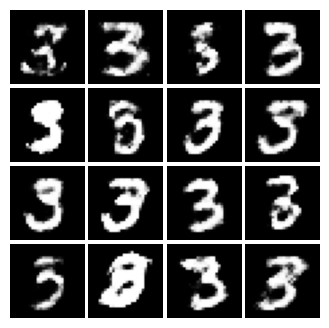

In [ ]:
# Hyperparameters
mb_size = 64
Z_dim = 1000
h_dim = 128
lr = 1e-3

# Load MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the 28x28 image to 784
])

train_dataset = datasets.MNIST(root='../MNIST', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=mb_size, shuffle=True)

X_dim = 784  # 28 x 28
y_dim= 10 #label dimension size

# Xavier Initialization
def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Generator
# z dim is the noise vector, that the generator initially samples from, then passes it through the hidden layer
# of size h_dim, and produce output of size x_dim
class Generator(nn.Module):
    def __init__(self, z_dim, y_dim, h_dim, x_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim+y_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, x_dim)
        self.apply(xavier_init)

    def forward(self, z,y):
        inputs = torch.cat([z, y], dim=1)  # Concatenate noise and one-hot label
        h = F.relu(self.fc1(inputs))
        out = torch.sigmoid(self.fc2(h))
        return out

# Discriminator
# x_dim is the size of the fake image, then it passes it through a hidden_layer of size h_dim and produces output
# of dimension 1 (binary - yes or no)
class Discriminator(nn.Module):
    def __init__ (self, x_dim, y_dim, h_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(x_dim+y_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 1)
        self.apply(xavier_init)

    def forward(self, x, y):
        inputs = torch.cat([x, y], dim=1)  # Concatenate image and one-hot label
        h = F.relu(self.fc1(inputs))
        out = torch.sigmoid(self.fc2(h))
        return out

# Training
def cGANTraining(G, D, loss_fn, train_loader):
    G.train()
    D.train()

    D_loss_real_total = 0
    D_loss_fake_total = 0
    G_loss_total = 0
    # gives a progress bar for train loader
    t = tqdm.tqdm(train_loader)
    
    for it, (X_real, labels) in enumerate(t):
        X_real = X_real.float().to(device)
        labels = labels.to(device)

        # one hot encoding of the labels
        y = F.one_hot(labels, num_classes=y_dim).float()

        # sample noise and labels
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        ones_label = torch.ones(X_real.size(0), 1).to(device)
        zeros_label = torch.zeros(X_real.size(0), 1).to(device)

        # discriminator
        G_sample = G(z,y)
        D_real = D(X_real,y)
        # detach the forward prop from the original generator's gradients. We are training the discriminator,
        # don't touch the generator's gradients
        D_fake = D(G_sample.detach(),y)

        D_loss_real = loss_fn(D_real, ones_label)
        D_loss_fake = loss_fn(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake
        D_loss_real_total += D_loss_real.item()
        D_loss_fake_total += D_loss_fake.item()

        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()

        # generator
        # resample z and g_sample since the previous G_sample was detached
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        G_sample = G(z,y)
        D_fake = D(G_sample, y)

        G_loss = loss_fn(D_fake, ones_label)
        G_loss_total += G_loss.item()

        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()

    D_loss_real_avg = D_loss_real_total / len(train_loader)
    D_loss_fake_avg = D_loss_fake_total / len(train_loader)
    D_loss_avg = D_loss_real_avg + D_loss_fake_avg
    G_loss_avg = G_loss_total / len(train_loader)

    wandb.log({
        "D_loss_real": D_loss_real_avg,
        "D_loss_fake": D_loss_fake_avg,
        "D_loss": D_loss_avg,
        "G_loss": G_loss_avg
    })

    return G, D, G_loss_avg, D_loss_avg
    

def save_sample(G, epoch, mb_size, Z_dim, y_dim, digit=3):
    out_dir = "out_cgan"
    G.eval()
    with torch.no_grad():
        z = torch.randn(mb_size, Z_dim).to(device)

        # Create one-hot labels for the specified digit
        y = torch.full((mb_size,), digit, dtype=torch.long).to(device)
        y_one_hot = F.one_hot(y, num_classes=y_dim).float()

        # Generate images conditioned on that digit
        samples = G(z, y_one_hot).detach().cpu().numpy()[:16]

    # Plotting
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    if not os.path.exists(f'{out_dir}'):
        os.makedirs(f'{out_dir}')
    plt.savefig(f'{out_dir}/{str(epoch).zfill(3)}.png', bbox_inches='tight')
    plt.close(fig)

wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# instantiate models
G = Generator(Z_dim, y_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, y_dim, h_dim).to(device)

# optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# loss function
def my_bce_loss(preds, targets):
    return F.binary_cross_entropy(preds, targets)

#loss_fn = nn.BCEWithLogitsLoss()
loss_fn = my_bce_loss

if wandb_log: 
    wandb.init(project="conditional-gan-mnist")

    # Log hyperparameters
    wandb.config.update({
        "batch_size": mb_size,
        "Z_dim": Z_dim,
        "X_dim": X_dim,
        "h_dim": h_dim,
        "lr": lr,
    })

best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

#Train epochs
epochs = 50

for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg= cGANTraining(G, D, loss_fn, train_loader)

    print(f'epoch{epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim, y_dim=10, digit=3)

def generate_digit_samples(G, digit, Z_dim, y_dim, num_samples=16, save_path=None):
    G.eval()
    with torch.no_grad():
        # Generate random noise
        z = torch.randn(num_samples, Z_dim).to(device)
        
        # Create a one-hot label for the chosen digit
        y = torch.full((num_samples,), digit, dtype=torch.long).to(device)
        y_one_hot = F.one_hot(y, num_classes=y_dim).float()
        
        # Generate images
        samples = G(z, y_one_hot).detach().cpu().numpy()

    # Plot the generated images
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# generate the digit 3
generate_digit_samples(G, digit=3, Z_dim=Z_dim, y_dim=10)

# Inference    
# G.load_state_dict(torch.load('checkpoints/G_best.pth'))
# G.eval()

# save_sample(G, "best", mb_size, Z_dim)

TASK 4

First, train a CNN MNIST model and create adversarial images to classify 4s as 9s. HINT:
Take help from Jasoni Carter GitHub Try to reason how these adversar-ial images are pro-
duced. Next, a random noise image was used to classify it as nine and observe the results.
Compare the results from the first and the second steps.

How this is done:

We calculates the gradient of the loss to the intended misclassified number (9) with respect to the image (4).

The sign of the gradient tells the direction in which changing the pixel will most increase the model's error (for the wrong label).

We nudges the image slightly in that direction (adds very small noise).

In [ ]:
# simple cnn

# MNIST Data
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./MNIST', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./MNIST', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# train
epochs = 5
for epoch in range(epochs):
    model.train()
    for (data, target) in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

# Evaluate
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for (data, target) in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)
print(f"Test Accuracy: {100 * correct / total:.2f}%")


Epoch 1: Loss = 0.0761
Epoch 2: Loss = 0.0014
Epoch 3: Loss = 0.0431
Epoch 4: Loss = 0.0257
Epoch 5: Loss = 0.0003
Test Accuracy: 98.87%


In [6]:
def create_adversarial_image(model, x_image, y_label, lr=0.1, n_steps=1, output_probs=False):
    model.eval()

    # clone the original image to generate the adversarial image
    x_adv = x_image.clone().detach().requires_grad_(True).to(device)
    y_label = y_label.to(device)

    probs_per_step = []

    for _ in range(n_steps):
        output = model(x_adv)
        loss = F.cross_entropy(output, y_label)
        
        # Backward to calculate gradients
        model.zero_grad()
        loss.backward()
        
        # Take a step in the direction of the gradient (sign method), to maximise loss, making sure that the discriminator can be fooled as best as possible
        grad_sign = x_adv.grad.sign()
        x_adv = (x_adv - lr * grad_sign / n_steps).detach()
        x_adv.requires_grad = True
        
        # Clip image to [0,1], making sure that there is no negative values for the image
        x_adv = torch.clamp(x_adv, 0, 1)

        if output_probs:
            probs = F.softmax(output, dim=1).detach().cpu().numpy()
            probs_per_step.append(probs)

    return x_adv, probs_per_step



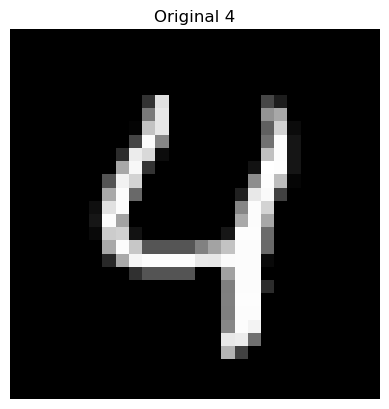

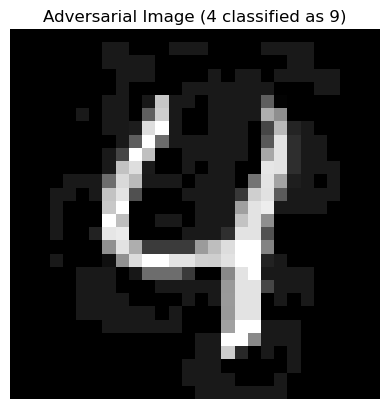

Prediction after adversarial attack: 4


In [7]:
# Pick one 4 from test set
for (data, target) in test_loader:
    idx = (target == 4).nonzero(as_tuple=True)[0]
    if len(idx) > 0:
        img_real_4 = data[idx[0]].unsqueeze(0).to(device)  # [1,1,28,28]
        label_target_9 = torch.tensor([9]).to(device)  # We want to misclassify it as 9
        break

# Plot the original 4
import matplotlib.pyplot as plt

plt.imshow(img_real_4.squeeze().cpu().numpy(), cmap="gray")
plt.title("Original 4")
plt.axis('off')
plt.show()

# Create adversarial example
adv_image, _ = create_adversarial_image(model, img_real_4, label_target_9, lr=0.1, n_steps=1)

# Plot adversarial example
plt.imshow(adv_image.squeeze().cpu().detach().numpy(), cmap="gray")
plt.title("Adversarial Image (4 classified as 9)")
plt.axis('off')
plt.show()

# Check prediction
model.eval()
with torch.no_grad():
    output = model(adv_image)
    pred_label = output.argmax(dim=1).item()

print(f"Prediction after adversarial attack: {pred_label}")


Random noise to be classified as a 9

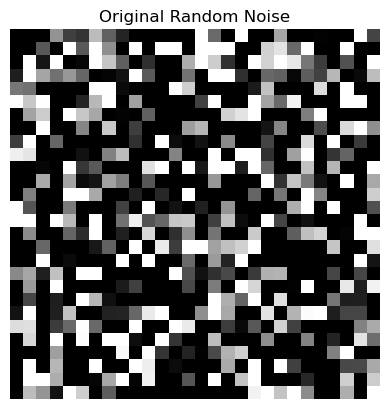

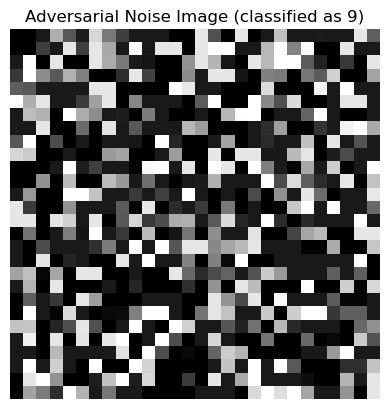

Prediction after adversarial attack on random noise: 5


In [8]:
random_noise = torch.randn((1, 1, 28, 28), device=device)
random_noise = torch.clamp(random_noise, 0, 1)  # Make sure pixel values are between [0,1]

label_target_9 = torch.tensor([9], device=device)


plt.imshow(random_noise.squeeze().cpu().numpy(), cmap="gray")
plt.title("Original Random Noise")
plt.axis('off')
plt.show()

# create adversarial example
adv_noise_image, _ = create_adversarial_image(model, random_noise, label_target_9, lr=0.1, n_steps=1)

# plot adversarial noise image
plt.imshow(adv_noise_image.squeeze().cpu().detach().numpy(), cmap="gray")
plt.title("Adversarial Noise Image (classified as 9)")
plt.axis('off')
plt.show()

# check prediction
model.eval()
with torch.no_grad():
    output = model(adv_noise_image)
    pred_label_noise = output.argmax(dim=1).item()

print(f"Prediction after adversarial attack on random noise: {pred_label_noise}")


It is more difficult for an adversarial image created from random noise to be misclassified, and the image generated will be more blurry as well. This is because if we start from a 4 for example, the image is already close to the distribution of digits (i.e, the pixel pattern on the image is close to the image that our model is already trained on), therefore, small changes (tiny noise) can easily confuse the model. However, if we use random noise instead, the image could be in any pixel pattern, and it will be hard for us to pinpoint the exact type of noise to introduce in order for us to misclassify an image

TASK 5

Now, you will implement a stable diffusion model to generate images based on MNIST.
Stable diffusion models are complex and costly, so take inspiration from this article this
article, which shows you how to create a simple, stable diffusion model. Train the diffusion
model to generate images of any desired number, and compare the results with the images
from your CGAN (task 2.3). What is the main difference between GAN and stable diffusion?

The model starts from pure noise and denoises gradually, predicting the noise added at each timestep. Compared to the CGAN trained earlier, the diffusion model produces images that are blurrier and slower to generate but with more stable training behavior. In contrast, the CGAN directly generates samples in one step but requires careful balancing between Generator and Discriminator to avoid issues like mode collapse. The main difference between GANs and Diffusion models is that GANs generate images in one shot using adversarial training, while Diffusion models iteratively denoise noise over many steps without adversarial competition

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data prep
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Lambda(lambda x: (x * 2) - 1)  # Normalize to [-1, 1]
])

train_dataset = datasets.MNIST(root='./MNIST', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# diffusion parameters
T = 300  # Total timesteps
beta = torch.linspace(1e-4, 0.02, T).to(device)  # Linear schedule
alpha = 1. - beta
alpha_hat = torch.cumprod(alpha, dim=0)

# forward diffusion 
def forward_diffusion_sample(x_0, t, device=device):
    """Adds noise to image at step t"""
    noise = torch.randn_like(x_0).to(device)
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t])[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t])[:, None, None, None]
    return sqrt_alpha_hat * x_0 + sqrt_one_minus_alpha_hat * noise, noise

# define a simple cnn
class DenoiseMLP(nn.Module):
    def __init__(self):
        super(DenoiseMLP, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*28*28, 1024)
        self.fc2 = nn.Linear(1024, 1*28*28)

    def forward(self, x, t):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 1, 28, 28)
        return x

model = DenoiseMLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
mse = nn.MSELoss()

epochs = 250

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for step, (x, _) in enumerate(train_loader):
        x = x.to(device)
        batch_size = x.size(0)
        t = torch.randint(0, T, (batch_size,), device=device).long()
        
        x_noisy, noise = forward_diffusion_sample(x, t, device)
        
        noise_pred = model(x_noisy, t)
        
        loss = mse(noise, noise_pred)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")

# Save model
os.makedirs("diffusion_checkpoints", exist_ok=True)
torch.save(model.state_dict(), 'diffusion_checkpoints/diffusion_mnist.pth')


Epoch 1: Loss = 0.9967
Epoch 2: Loss = 0.9942
Epoch 3: Loss = 0.9942
Epoch 4: Loss = 0.9937
Epoch 5: Loss = 0.9937
Epoch 6: Loss = 0.9935
Epoch 7: Loss = 0.9930
Epoch 8: Loss = 0.9931
Epoch 9: Loss = 0.9934
Epoch 10: Loss = 0.9932
Epoch 11: Loss = 0.9933
Epoch 12: Loss = 0.9931
Epoch 13: Loss = 0.9930
Epoch 14: Loss = 0.9929
Epoch 15: Loss = 0.9928
Epoch 16: Loss = 0.9919
Epoch 17: Loss = 0.9896
Epoch 18: Loss = 0.9878
Epoch 19: Loss = 0.9874
Epoch 20: Loss = 0.9872
Epoch 21: Loss = 0.9870
Epoch 22: Loss = 0.9868
Epoch 23: Loss = 0.9862
Epoch 24: Loss = 0.9853
Epoch 25: Loss = 0.9846
Epoch 26: Loss = 0.9845
Epoch 27: Loss = 0.9848
Epoch 28: Loss = 0.9845
Epoch 29: Loss = 0.9845
Epoch 30: Loss = 0.9847
Epoch 31: Loss = 0.9847
Epoch 32: Loss = 0.9843
Epoch 33: Loss = 0.9846
Epoch 34: Loss = 0.9845
Epoch 35: Loss = 0.9845
Epoch 36: Loss = 0.9841
Epoch 37: Loss = 0.9844
Epoch 38: Loss = 0.9842
Epoch 39: Loss = 0.9841
Epoch 40: Loss = 0.9843
Epoch 41: Loss = 0.9847
Epoch 42: Loss = 0.9845
E

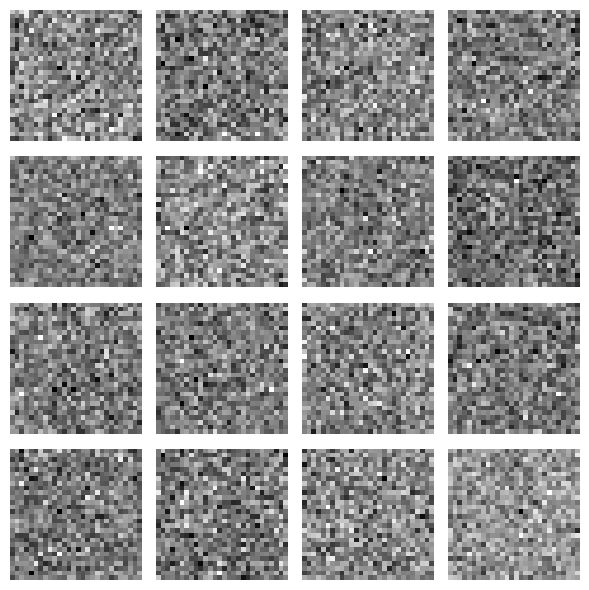

In [12]:
import matplotlib
# Function to sample from the diffusion model
@torch.no_grad()
def sample(model, n_samples):
    model.eval()
    x = torch.randn((n_samples, 1, 28, 28)).to(device)

    for t in reversed(range(T)):
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        pred_noise = model(x, t_batch)

        alpha_t = alpha[t]
        alpha_hat_t = alpha_hat[t]
        beta_t = beta[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (1/torch.sqrt(alpha_t)) * (x - (1 - alpha_t)/torch.sqrt(1 - alpha_hat_t) * pred_noise) + torch.sqrt(beta_t) * noise

    x = (x + 1) / 2  # Rescale to [0, 1]
    return x

# Generate and plot samples
samples = sample(model, n_samples=16)

fig, axes = plt.subplots(4, 4, figsize=(6,6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].squeeze().cpu().numpy(), cmap="gray")
    ax.axis('off')
plt.tight_layout()
plt.show()
